# Evaluation de la qualités des données textuelles : 

Objectifs : 

Dans ce notebook nous allons créer un nouveau fichier CSV contenant des informations supplémentaires sur les textes. Ce fichier nous permettra de gagner une meilleure compréhension des comptes rendus tout en interrogeant nos outils informatiques en juxtaposant différents résultats issus de différents traitements. 

Nous procéderons à l'extraction de données en croisant différentes approches de la fouille de texte notamment : 

- En sollicitant la librairie Spacy qui permet de rechercher des entités nommées. SpaCy est une bibliothèque populaire pour ce type d'analyse en Python. Elle fournit un modèle pré-entraîné sur une très grande quantité de textes et propose des modèles en plusieurs langues. 

- En sollicitant les expressions régulières, ce qui permet de rechercher des formes d'objets textuels. La bibliothèque re (regular expression) est une librairie Python qui fournit un ensemble de fonctions permettant de fouiller et nettoyer des documents texte. Elle nous permettra de rechercher des motifs définis sous la forme d'une expression régulière dans le texte, sous forme de chaîne de caractères. Si l'objet est identifié ("matché"), alors nous pouvons compiler et ainsi créer une nouvelle colonne contenant ces informations. 

De fait, il s'agit ici de croiser cette approche que nous pouvons qualifier de "formelle", puisque nous fouillons le texte en ciblant une forme d'objets, avec une approche qui se base plus sur des concepts sémantiques comme l'identification des entités nommées fournie par spaCy. La reconnaissance d'entités nommées (aussi appelé NER) est une méthode de traitement du langage naturel. Avec cette technique il nous est possible d'identifier des noms propres ou communs, des lieux ou des noms d'institution par exemple. Cependant, il serait également intéressant d'analyser du vocabulaire comme les phrases et les verbes présent dans l'étendue du corpus. 

Présentation du jeu de données : 

corpus.csv 

Description des colonnes : 

[title] = Contient le titre du comptes rendus 

[pers] = contient les noms présent dans les comptes-rendus extraient préalablement avec la librairie spaCy

[texte_titre] = contient le textes et le titre des comptes-rendus 

Exportation des résultat sous le forme de : "evaluation_qualite_donnes_txt.csv"

# Installation et importation :

## Installation pip : 

In [2]:
!pip install pyLDAvis==3.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 KB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 75.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9239305e4ee09e23edcfa82cd9f918aa8a0d0656c0a8d51aa890ce18918d024e
  Stored in directory: /root/.cache/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=be3c1f6972e224cb58bdf

In [3]:
!pip install wordcloud==1.8.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 45.9 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Dans le terminal :
# python -m spacy download fr_core_news_sm

In [4]:
!pip install stop_words==2018.7.23

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=6e7027d3e20b0268be0394d4dca28d86529742c18db49d4ffcb1b06d2f2918fc
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop_words
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Importation des librairies :

In [5]:
# Importation des librairies
#python -m spacy download fr_core_news_sm
import re
import numpy as np
import pandas as pd
from pprint import pprint

# spacy for lemmatization
import spacy
import fr_core_news_sm
nlp = fr_core_news_sm.load()
 
from stop_words import get_stop_words
stop_words = get_stop_words('french')

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-25 04:40:42.789970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 04:40:42.938364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 04:40:42.938394: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
202

## Importation du jeu de données : 

In [6]:
#Importation du fichier : 

df = pd.read_table("corpus.csv",sep=";",header=0)

In [7]:
# Observation des caractéristiques du tableau : 
print(type(df))
print(len(df))

<class 'pandas.core.frame.DataFrame'>
1933


Nous observons que nous avons un document de type data frame contenant 1933 lignes. 

Chaque ligne correspond à un compte rendu. 

In [8]:
df

,Unnamed: 0,title,texte_titre,pers
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall..."
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex..."
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'..."
...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']"
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 'Maximin', ..."
1930,1930,Étienne Moreau-Nélaton. Histoire de Fère-en-Ta...,Etienne Moreau-Nélaton. Histoire de Fère-en-Ta...,"['Etienne Moreau-Nélaton', 'Frédéric Moreau', ..."
1931,1931,ΕΠΙΤΥΜΒΙΟΝ. Heinrich Swoboda dargestellt,EIIITYMBION. Heinrich Swoboda dargestellt. Un ...,"['Heinrich Swoboda', 'Hans Hirsch', 'Arthur St..."


# Extraction d'informations :

In [17]:
from stop_words import get_stop_words


# Get the set of French stopwords
stop_words = set(get_stop_words('fr'))
print ("mots outils :", len (stop_words))

# Elargir la liste des stopwords 
stop_words.update(["of","the","as", "der","die","das", "to","see","say","and","to", "comme","celle", "ici", "deja", "sous", "chez","tout","ce","ci","aussi", "dont", "elles","mem", "yal","cela","etc","celui","lui","ii","ete","ainsi","entre",'jusqu',"meme","ceu","elle","il"])
print("mots outils élargient :",len(stop_words))

# create a new set of stopwords that are capitalized versions of the original stopwords
stopwords_capitalized = {word.capitalize() for word in stop_words}

# update the original set of stopwords with the capitalized versions
stop_words.update(stopwords_capitalized)
print ("liste de mots ouils élargie avec mots ouils en majuscule :", len (stop_words))


mots outils : 247
mots outils élargient : 271
liste de mots ouils élargie avec mots ouils en majuscule : 542


### Identification de problèmes d'OCR :

In [18]:
import binascii

# Fonction pour analyser si l'ocr contient des erreurs invisibles : 
def check_invisible_errors(text):
    for word in text.split():
        hex_word = binascii.hexlify(word.encode())
        print(f'{word} : {hex_word}')

# Regarder dans les comptes rendus (nous répétons cette étape quelques fois ): 
df = df
line_number = int(input("Entrer un numero d'index 0 à 1933 : "))

# Chercher le texte du compte rendu séléctioné : 
text = df.at[line_number, "texte_titre"]

# Appeler la fonction
check_invisible_errors(text)

Service : b'53657276696365'
des : b'646573'
Antiquités : b'416e746971756974c3a973'
de : b'6465'
l" : b'6c22'
Egypte. : b'4567797074652e'
Fouilles : b'466f75696c6c6573'
à : b'c3a0'
Saqqarah. : b'53617171617261682e'
Le : b'4c65'
MastabatFaraoim,par : b'4d61737461626174466172616f696d2c706172'
G. : b'472e'
JÉQUiER,avec : b'4ac38951556945522c61766563'
la : b'6c61'
collaboration : b'636f6c6c61626f726174696f6e'
de : b'6465'
Dows : b'446f7773'
Dunham. : b'44756e68616d2e'
Un : b'556e'
vol. : b'766f6c2e'
in-4°, : b'696e2d34c2b02c'
44 : b'3434'
p., : b'702e2c'
38 : b'3338'
illustrations : b'696c6c757374726174696f6e73'
dans : b'64616e73'
le : b'6c65'
texte : b'7465787465'
et : b'6574'
13 : b'3133'
planches : b'706c616e63686573'
hors : b'686f7273'
texte. : b'74657874652e'
Le : b'4c65'
Caire, : b'43616972652c'
1928. : b'313932382e'
Les : b'4c6573'
touristes : b'746f75726973746573'
qui : b'717569'
visitent : b'7669736974656e74'
la : b'6c61'
partie : b'706172746965'
Nord : b'4e6f7264'
de : b'6465'
la 

Après quelques tests nous constatons peu d'erreur dans les représentations hexadécimales. Voici un exemple d’erreurs que nous avons pu identifier dans le jeu de données : ’et : b'276574' au lieu de 'et : b'6574'. Le caractère '2' n'est pas la représentation correcte de la lettre 'e' dans la table ASCII. Des erreurs de ce type peuvent causer des problèmes dans le traitement ultérieur. Ici nous avons donc vérifier si l'OCR ne contient pas d'erreur invisible.  

### Expressions régulières :

In [19]:
#Création de deux nouvelles colonnes [noms] [dates] [cleaned_text]
#Création de deux listes pour stocker les informations extraites
s :

text_column = "texte_titre"

cleaned_text = []
names = []
dates = []


# Boucle qui regarde chaque texte des comptes-rendus stoqués dans texte_titre : 

for index, row in df.iterrows():
    #Nettoyage_stopwords :  
    text = row[text_column]
    cleaned_text.append(" ".join([word for word in text.split() if word not in stop_words]))

# Ajout des extractions dans le dataframe : 
df["cleaned_text"] = cleaned_text

# Extraction des noms utilisant des expression régulieres 
#(extraction grossière tout ce qui comencera par une majuscule sera extrait)
for index, row in df.iterrows():
    text = row[text_column]
    # extract names from the text using a regular expression
    extracted_names = re.findall(r"[A-Z][a-z]+", text)
    names.append(extracted_names)
    
    # Extraction des dats utilisant des expression régulieres 
    #(extraction grossière untiquement les dates sous forme de 1900 seront récoltées)
    extracted_dates = re.findall(r"\d{4}", text)
    dates.append(extracted_dates)

# Ajout des extractions dans le dataframe : 
df["noms"] = names
df["dates"] = dates

#Affichage : 
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[]
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]"
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]"
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]"
...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[]
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 'Maximin', ...",Émilienne Demougeot. formation l'Europe invasi...,"[Demougeot, La, Europe, Des, Dioct, Paris, Aub...","[1969, 1951, 1971, 1967]"
1930,1930,Étienne Moreau-Nélaton. Histoire de Fère-en-Ta...,Etienne Moreau-Nélaton. Histoire de Fère-en-Ta...,"['Etienne Moreau-Nélaton', 'Frédéric Moreau', ...",Etienne Moreau-Nélaton. Histoire Fère-en-Tarde...,"[Etienne, Moreau, Histoire, Tardenois, Paris, ...","[1779, 1756, 1882, 1911]"
1931,1931,ΕΠΙΤΥΜΒΙΟΝ. Heinrich Swoboda dargestellt,EIIITYMBION. Heinrich Swoboda dargestellt. Un ...,"['Heinrich Swoboda', 'Hans Hirsch', 'Arthur St...",EIIITYMBION. Heinrich Swoboda dargestellt. vol...,"[Heinrich, Swoboda, Un, Reichenberg, Verlag, G...","[1927, 1856, 1926]"


Interprétation : En comparant la colonne [pers] qui contient les noms de personnes extraits avec spaCy et [noms] qui contient les noms extraits avec une expression régulière, nous observons que l'extraction par la méthode des entités nommées de noms de personnes est bien plus propre et performante que celle réalisée par recherche avec des expressions régulières. Cependant, les regex se révèlent efficaces pour réaliser une extraction brute de données afin d'avoir une première vue globale sur un contenu plus large des comptes rendus. De fait, les expressions régulières ne sont pas à être écartées du traitement, puisqu'ils permettent également de comparer ces deux approches en nous donnant un retour positif sur l'emploi des entités nommées pour la recherche plus fine. 

Pour les dates nous observons quelques erreurs du aux erreurs d'ocr. Par exemple à la colonnes 4 dans ["textes_titres "] nous avons "119^" au lieu de la date complète, ce qui cause des pertes. 

### Mme. et M. 

In [20]:
# Recherche des mentions de personnes selon le genre : 
# Mme., mme. et madame pour le genre féminin 
# M., m. et monsieur pour le genre masculin 

import re

# Définition qui parcour le texte et qui compte le mombre d'élément identifié par les regex. 
def count_genders(text):
    m_count = len(re.findall(r"(M|m)\.", text)) # utilisant l'expresion "|"" (ou) 
    monsieur_count = len(re.findall(r"monsieur", text, re.IGNORECASE)) # utilisant la fonction re.IGNORECASE 
    mme_count = len(re.findall(r"(Mme|mme)", text))
    madame_count = len(re.findall(r"madame", text, re.IGNORECASE))
    return (m_count + monsieur_count, mme_count + madame_count)

df["homme"], df["femme"] = zip(*df["texte_titre"].apply(count_genders))

#Affichage : 
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0
...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 'Maximin', ...",Émilienne Demougeot. formation l'Europe invasi...,"[Demougeot, La, Europe, Des, Dioct, Paris, Aub...","[1969, 1951, 1971, 1967]",0,7
1930,1930,Étienne Moreau-Nélaton. Histoire de Fère-en-Ta...,Etienne Moreau-Nélaton. Histoire de Fère-en-Ta...,"['Etienne Moreau-Nélaton', 'Frédéric Moreau', ...",Etienne Moreau-Nélaton. Histoire Fère-en-Tarde...,"[Etienne, Moreau, Histoire, Tardenois, Paris, ...","[1779, 1756, 1882, 1911]",4,7
1931,1931,ΕΠΙΤΥΜΒΙΟΝ. Heinrich Swoboda dargestellt,EIIITYMBION. Heinrich Swoboda dargestellt. Un ...,"['Heinrich Swoboda', 'Hans Hirsch', 'Arthur St...",EIIITYMBION. Heinrich Swoboda dargestellt. vol...,"[Heinrich, Swoboda, Un, Reichenberg, Verlag, G...","[1927, 1856, 1926]",1,0


In [21]:
homme_values = df['homme'].astype(int).tolist()
femme_values = df['femme'].astype(int).tolist()

print(sum(homme_values))
print(sum(femme_values))

7900
7666


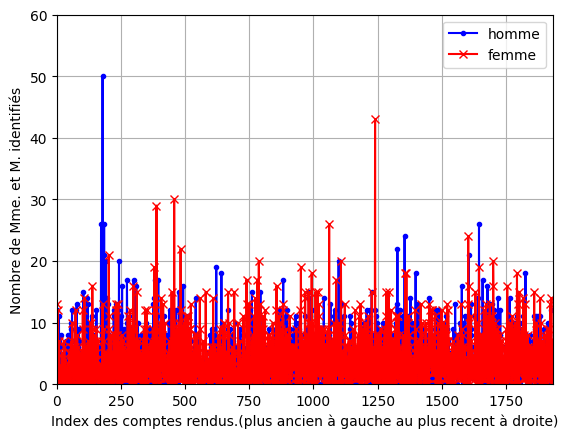

In [22]:
import matplotlib.pyplot as plt

# Création d'un graphique pour afficher le nombre de Mme et M dans les comptes rendus : 
# Pour la colonne 'homme'
plt.plot(df.index, df['homme'], marker='.',color='blue')

# Pour la colonne 'femme' 
plt.plot(df.index, df['femme'], marker='x',color='red')


# Ajout d'une légende 
plt.legend(['homme', 'femme'])

# Add labels for the x and y axis
plt.xlabel('Index des comptes rendus.(plus ancien à gauche au plus recent à droite)')
plt.ylabel('Nombre de Mme. et M. identifiés')

plt.grid()

plt.xlim(0, len(df))
plt.ylim(0, max(df['homme'].max(), df['femme'].max())+10)

# Show the plot
plt.show()

Interprétation : 

Il a été intéressant pour nous d'interroger la distribution des références aux “Mme./Madame” et “M./Monsieur” dans les textes. En effet, dans nos théories initiales, nous pensions ne pas trouver beaucoup de références au genre féminin. Certes, il reste à regarder dans quel contexte celles-ci sont mentionnées, mais néanmoins nous observons qu'elles ne sont en aucun cas absentes des comptes-rendus. 
Cependant, il est important de noter que les auteurs sont souvent nommés par leurs noms. De fait, il faut prendre un certaine distance avec les résultats, qui laisserait ici supposer qu'il y a une égalité du genre.  Des conclusions trop hâtives sont alors à écarter et nous ne devons pas considérer ici que les comptes rendus parlent, donnent la parole ou citent des ouvrages rédigés par des femmes autant que par des hommes. Il suffit de jeter un coup d'œil à la colonne "pers", contenant les noms extraits avec les entités nommées pour s'en apercevoir.


### Taille / Ponctuation / Mots fréquents

In [31]:
from collections import Counter

# Création de nouvelles colones ["titre de colone"] : 
df["taille_texte"] = 0
df["nb_phrases"] = 0
df["nb_virgule"] = 0
df["mot_freq_clean"] = ""
df["mot_freq_brut"] = ""

# Boucle qui cible chque texte contenu dans la colonne 'texte_titre' :
for index, row in df.iterrows():

    # Calculer la taille du texte :
    df.at[index, "taille_texte"] = len(row["texte_titre"])

    # Comptage du nombre de '.?!' dans le texte : 
    # (cela nous donne une valeur approximative du nombre de phrases contenu dans les documents)
    df.at[index, "nb_phrases"] = sum([row["texte_titre"].count(punct) for punct in ".!?"])

    # Compter le nombre de virgule dans le ',' texte : 
    df.at[index, "nb_virgule"] = row["texte_titre"].count(",")


# Mot fréquents sur textes brut : 
# Séparation du texte en mots istolé : 
    mots = row["texte_titre"].split()

# Calculer la frequence pour chaque mots dans chaque texte avec Counter(words) :
    mot_frequency = Counter(mots)

# Les 10 mots les plus fréquent sur texte clean:
    most_common = mot_frequency.most_common(10)
    most_common_mot = [mot[0] for mot in most_common]
    df.at[index, "mot_freq_brut"] = most_common_mot


# Mot fréquents sur textes clean : 
# Séparation du texte en mots istolé : 
    mots_clean = row["cleaned_text"].split()
    
# Calculer la frequence pour chaque mot dans chaque texte avec Counter(words) :
    mot_frequency_clean = Counter(mots_clean)

# Les 10 mots les plus fréquents :
    most_common_clean =  mot_frequency_clean.most_common(10)
    most_common_mot_clean = [mot[0] for mot in most_common_clean]
    df.at[index, "mot_freq_clean"] = most_common_mot_clean

#Affichage : 
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,nb_phrases,nb_virgule,mot_frequent,mot_freq_clean,mot_freq_brut
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,46,64,"[de, et, les, à, la, est, le, que, pour, M.]","[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]"
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,49,76,"[de, la, le, à, du, en, et, un, qui, M.]","[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]"
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,28,40,"[de, et, la, du, à, le, Thackeray, est, en, que]","[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]"
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,41,91,"[de, la, et, des, à, le, les, «, une, du]","[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]"
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,29,30,"[de, des, et, les, du, la, le, à, actes, monas...","[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,6,7,"[la, de, en, :, à, des, Lesne., propriété, ecc...","[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, Lesne., propriété, ecc..."
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 'Maximin', ...",Émilienne Demougeot. formation l'Europe invasi...,"[Demougeot, La, Europe, Des, Dioct, Paris, Aub...","[1969, 1951, 1971, 1967]",0,7,6193,44,77,"[de, la, les, et, des, du, à, le, en, sur]","[invasions, ?, Germanie, Mlle, Demougeot, Germ...","[de, la, les, et, des, du, à, le, en, sur]"
1930,1930,Étienne Moreau-Nélaton. Histoire de Fère-en-Ta...,Etienne Moreau-Nélaton. Histoire de Fère-en-Ta...,"['Etienne Moreau-Nélaton', 'Frédéric Moreau', ...",Etienne Moreau-Nélaton. Histoire Fère-en-Tarde...,"[Etienne, Moreau, Histoire, Tardenois, Paris, ...","[1779, 1756, 1882, 1911]",4,7,6333,49,83,"[de, et, la, des, à, les, du, le, qui, un]","[plus, château, d'une, M., l'histoire, l'auteu...","[de, et, la, des, à, les, du, le, qui, un]"
1931,1931,ΕΠΙΤΥΜΒΙΟΝ. Heinrich Swoboda dargestellt,EIIITYMBION. Heinrich Swoboda dargestellt. Un ...,"['Heinrich Swoboda', 'Hans Hirsch', 'Arthur St...",EIIITYMBION. Heinrich Swoboda dargestellt. vol...,"[Heinrich, Swoboda, Un, Reiche

Interprétation : 
df["taille_texte"] : La taille est une valeur importante des textes. Elle peut être exploitée de manière à analyser la taille des documents en fonction d'autres critères comme la date par exemple. De même, elle peut être croisée avec des variables comme le nombre de phrases afin d'observer si oui ou non, il y a des changements au niveau du style de rédaction dans les comptes-rendus. 

df["nb_phrases"] : En recherchant le nombre de ponctuations de fin de phrases, à savoir "?", "!" ou ".", nous pouvons approximativement estimer le nombre de phrases présentes dans un compte-rendu. 

df["nb_virgule"] = Les virgules sont également extraites. 

Dans un souci d'illustrer l'importance de la suppression des mots outils, nous avons ici juxtaposé la même extraction de mots, mais réalisée sur deux documents différents. L'une se basant  sur le texte brut contenant les mots outils et l'autre sur le texte nettoyé des mots outils. 

Ainsi, ["mot_freq_brut"] et ["mot_freq_clean"] contiennent tous les deux les mots les plus fréquents d'un compte-rendu. Les mots les plus fréquents sont extraits, pour observer s'ils ont une valeur sémantique assez importante pour pouvoir avoir un aperçu thématique du texte. Nous remarquons que cela marche plutôt bien. En effet, nous avons ligne 1 pour "Le Service des Antiquités d'Égypte" des mots comme funéraire, roi et mastaba, ce qui permettrait de comprendre qu'il s'agit des fouilles de mastaba en Égypte. De même, nous observons dans la colonne ["mot_freq_brut"]  que celle-ci contient pratiquement que des mots outils, ce qui prouve que leur nettoyage est une étape inévitable.  

## Mots clés avec TF-IDF : 

### Importations 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

### Nettoyage Lemmatization : 

In [34]:
import spacy

# Load the French language model
nlp = spacy.load("fr_core_news_sm")

# Create a new column to store the lemmatized text
df["lemmatized_text"] = ""

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    # Get the text from the "texte_titre" column
    text = row["cleaned_text"]

    # Process the text with the spacy model
    doc = nlp(text)

    # Create a list to store the lemmatized words
    lemmatized_words = []

    # Iterate through the tokens in the processed text
    for token in doc:
        # Add the lemmatized form of the token to the list
        lemmatized_words.append(token.lemma_)

    # Join the list of lemmatized words into a single string
    lemmatized_text = " ".join(lemmatized_words)

    # Store the lemmatized text in the "lemmatized_text" column
    df.at[index, "lemmatized_text"] = lemmatized_text

# Display the updated DataFrame
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,nb_phrases,nb_virgule,mot_frequent,mot_freq_clean,mot_freq_brut,lemmatized_text
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,46,64,"[de, et, les, à, la, est, le, que, pour, M.]","[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,49,76,"[de, la, le, à, du, en, et, un, qui, M.]","[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,28,40,"[de, et, la, du, à, le, Thackeray, est, en, que]","[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ..."
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,41,91,"[de, la, et, des, à, le, les, «, une, du]","[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,29,30,"[de, des, et, les, du, la, le, à, actes, monas...","[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,6,7,"[la, de, en, :, à, des, Lesne., propriété, ecc...","[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, Lesne., propriété, ecc...",Emile Lesne . histoire propriété ecclésiastiqu...
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 'Maximin', ...",Émilienne Demougeot. formation l'Europe invasi...,"[Demougeot, La, Europe, Des, Dioct, Paris, Aub...","[1969, 1951, 1971, 1967]",0,7,6193,44,77,"[de, la, les, et, des, du, à, le, en, sur]","[invasions, ?, Germanie, Mlle, Demougeot, Germ...","[de, la, les, et, des, du, à, le, en, sur]",Émilienne Demougeot . formation le Europe inva...
1930,1930,Étienne Moreau-Nélaton. Histoire de Fère-en-Ta...,Etienne Moreau-Nélaton. Histoire de Fère-en-Ta...,"['Etienne Moreau-Nélaton', 'Frédéric Moreau', ...",Etienne Moreau-Nélaton. Histoire Fère-en-Tarde...,"[Etienne, Moreau, Histoire, Tardenois, Paris, ...","[1779, 1756, 1882, 1911]",4,7,6333,49,83,"

La lemmatisation est un processus qui nous permet de réduire le vocabulaire à leur racine sémantique. Par exemple, le verbe "est" deviendra "être". 

### Approche comparative :

In [42]:
tfidf = TfidfVectorizer()

mot_clef_brut = []
mot_clef_lem = []

# Boucle qui regarde chaque texte des comptes-rendus stoqués dans texte_titre : 
for index, row in df.iterrows():
    # Extraction des mots cléf utilisant TfidfVectorizer pour texte_titre
    tfidf_matrix = tfidf.fit_transform(df.loc[[index], "texte_titre"])
    mot_clef_brut.append([word for word in tfidf.get_feature_names() if word.isalpha()])

df["mot_cles_brut"] = mot_clef_brut

# Boucle qui regarde chaque texte des comptes-rendus stoqués dans lemmatized_text : 
for index, row in df.iterrows():
    # Extraction des mots cléf utilisant TfidfVectorizer pour lemmatized_text
    tfidf_matrix = tfidf.fit_transform(df.loc[[index], "lemmatized_text"])
    mot_clef_lem.append([word for word in tfidf.get_feature_names() if word.isalpha()])

df["mot_cles_lem"] = mot_clef_lem


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
#Affichage : 
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,nb_phrases,nb_virgule,mot_frequent,mot_freq_clean,mot_freq_brut,lemmatized_text,mot_cles_brut,mot_cles_lem
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,46,64,"[de, et, les, à, la, est, le, que, pour, M.]","[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....,"[absolue, absurde, accumulées, adopte, affirme...","[absolu, absurde, accumuler, adopte, affirmer,..."
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,49,76,"[de, la, le, à, du, en, et, un, qui, M.]","[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar...","[abandon, abandonnant, abondante, accompagné, ...","[abandon, abandonner, abondant, accompagner, a..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,28,40,"[de, et, la, du, à, le, Thackeray, est, en, que]","[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ...","[acceptée, achevé, ai, aimé, ainsi, alexander,...","[accepter, achever, aimé, alexander, alexandre..."
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,41,91,"[de, la, et, des, à, le, les, «, une, du]","[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...,"[académiciens, académie, académies, académique...","[académicien, académie, académique, accabler, ..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,29,30,"[de, des, et, les, du, la, le, à, actes, monas...","[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...,"[abondants, accepter, acte, actes, afin, agit,...","[abondant, accepter, act, acte, actes, afin, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,6,7,"[la, de, en, :, à, des, Lesne., propriété, ecc...","[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, Lesne., propriété, ecc...",Emile Lesne . histoire propriété ecclésiastiqu...,"[achever, arrête, au, auteur, aux, aînés, bonn...","[achever, arrête, auteur, aîné, bon, canonique..."
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...,"['Mlle Demougeot', 'Jésus-Christ', 

Interprétation :
Ici, nous essayons d'extraire des mots clés en utilisant la méthode TfidfVectorizer. L'approche marche relativement bien, nous ne retenons ici que 15 mots qui sont censés être sémantiquement intéressant à extraire. 

Nous avons juxtaposé les df["mot_cles_lem"] et df["mot_cles_brut"] afin de comparer les approches. En effet, ainsi, nous obtenons dans le dataframe une représentation des mots importants extraits lorsque le texte n'est pas lemmatizé et lorsque celui-ci est bien lemmatizé. 

Nous pouvons conclure que le nettoyage et l'ordre dans le quelle celui-ci est exécuté influent considérablement sur les conclusions que nous pouvons en tirer. 

## SpaCy et entités nommées 

### Application sur des données en exemples: 

In [44]:
# Démonstration de la téchnique POS_tag de spaCy sur une phrase exemple : 

# Chargement du modèle de language francais de spaCy : 
nlp = spacy.load('fr_core_news_sm')

# Initiation d'une phrase exemple : 
doc_phrase_test = nlp("Je suis arrivée à Paris hier. Dans cette ville il y a beaucoup de grands Musées. Je pense rester 5 jours.")

# Boucle pour parcourir les tokens de la phrase et afficher les tags 
for token in doc_phrase_test:
    print(token.text, token.pos_)

Je PRON
suis AUX
arrivée VERB
à ADP
Paris PROPN
hier ADV
. PUNCT
Dans ADP
cette DET
ville NOUN
il PRON
y PRON
a VERB
beaucoup ADV
de ADP
grands ADJ
Musées NOUN
. PUNCT
Je PRON
pense VERB
rester VERB
5 NUM
jours NOUN
. PUNCT


In [45]:
# Test sur un compte rendu : 

doc_CR_test = nlp("(P. Vergili Maronis). Épigrammata et Priapea. Édition critique et explicative par E. Galletier. Un vol. in-8°, XV1-229P. Paris, Hachette, 19*0.  La thèse complémentaire de M. Gailetier est consacrée à cette partie de YAppendix Vergiliana généralement publiée sous le nom de Catalecta ou de Catalepta. M. Galletier commence par établir que ces deux noms ne signifient rien, que ni l'un ni l'autre n'a jamais été le titre du recueil : Suétone, dans sa biographie de Virgile, a dû écrire quelque chose comme fecit Kaxà Xe-TCTÔv Priapea, Epigrammata, Diras..., et les deux mots grecs, transcrits en latin et plus ou moins défigurés, auront été pris pour le nom d'un recueil de vers. M. Galletier pense qu'il faut distinguer entre les Priapea (les trois premières pièces) et les Epigrammata (les 16 autres, ou pour mieux dire les15 autres, car le quatrain Callida imago est certainement interpolé). Les Priapées ont dû être publiées au temps de Domitien, les Épigrammes au temps de Néron.  Les Priapées, qui font de larges emprunts à la phraséologie virgilienne, ne peuvent être de Virgile ; elles contiennent même des réminiscences de Tibulle. Elles sont sans doute de trois auteurs différents, la première étant la plus récente. Quant aux Epigrammes, M. Galletier adopte sur la question d'authenticité une attitude intermédiaire entre la négation absolue (Sabbadini, Gurcio), et la thèse conservatrice (Vollmer, Birt, Gubernatis). 11 regarde comme certainement virgiliennes les pièces V et Vili (Ite hinc et Villula), probablement aussi l'épigramme VII (Si licet), peut-être enfin la parodie de Catulle X (Sabinus Me). La pièce XIV (Si mihi) est une composition d'école, suggérée à un lecteur postérieur par les circonstances de la vie et de la mort de Virgile : de même pour la pièce XV (Vate Syracosio), composée au me ou ive siècle pour être attribuée à Varius et servir en  quelque sorte de signature au recueil. Les deux pièces à Octavius Musa, IV et XI (Quocumque ire et Qui deus), l'élégie IX à Messala (Pauca mihi), ne présentent rien qui permette de les attribuer à Virgile. L'épigramme III (Aspice quem) est un pur lieu commun d'école. Restent les pièces I (De qua saepe), II (Corinthiorum amator), VI (Socer beate), XII (Superbe Noctuine) et XIII (Jacere me). M. Galletier les attribue à un ou plusieurs poètes, contemporains et compatriotes de Virgile, et, comme lui, disciples de Catulle ; il pense ingénieusement qu'à part l'épigramme II (contre Cimber),les quatre autres forment les épisodes d'un petit roman d'amour. C'est sur ces dernières pièces, particulièrement sur II, VI, XII et XIII, que l'on pourrait lui chercher quelque chicane. La grande raison pour les refuser à Virgile est que le ton en est trop violent pour un poète si délicat. L'argument est discutable. A ce compte, on devrait déclarer inauthentique telle épigramme de Racine qui est sûrement de lui. Je dirais simplement pour ma part que les pièces en question peuvent être de Virgile, quoique cela ne semble guère probable.  Ce point mis à part, toute la discussion d'authenticité est excellente. M. Galletier se meut d'un vol aisé parmi les hypothèses contradictoires entassées par les critiques italiens ou allemands ; il les expose clairement, les réfute avec sûreté ; sa propre doctrine, appuyée à la fois sur une érudition très précise et sur un sens littéraire très fin, est la plus vraisemblable de toutes celles qui ont été proposées.  On lui saura gré aussi du chapitre d'étude littéraire qui termine l'introduction. Par l'examen du vocabulaire,. du style et de la métrique, il fait voir à quel point Priapées et Épigrammes ont subi l'influence de Catulle. H y a là encore une démonstration très pénétrante.  L'établissement du texte, les notes critiques, le commentaire ont été l'objet des plus grands soins. Je n'oserais pas affirmer que toutes les difficultés, qui sont innombrables, aient été résolues : par exemple, pour la pièce I, où M. Galletier suit l'interprétation de Birt et de Gubernatis, il me paraît difficile que tibi et mi/ti, si proches, ne s'opposent pas l'un à l'autre. Mais en général le nouvel éditeur réussit fort bien à critiquer les explications, souvent saugrenues, qu'ont accumulées ses devanciers ; il distingue à merveille entre le certain et le probable, le possible et l'absurde, et son commentaire, de même que toute sa publication, est une œuvre de bon sens et de finesse en même temps que de science.  René Pichon.")

# Boucle pour parcourir les tokens de la phrase et afficher les tags 
for token in doc_CR_test:
    print(token.text, token.pos_)

( PUNCT
P. PROPN
Vergili PROPN
Maronis PROPN
) PUNCT
. PUNCT
Épigrammata NOUN
et CCONJ
Priapea PROPN
. PUNCT
Édition NOUN
critique ADJ
et CCONJ
explicative ADJ
par ADP
E. NOUN
Galletier PROPN
. PUNCT
Un DET
vol NOUN
. PUNCT
in-8 NOUN
° NOUN
, PUNCT
XV1 NOUN
- NOUN
229P. NOUN
Paris PROPN
, PUNCT
Hachette PRON
, PUNCT
19 NUM
* NOUN
0 NUM
. PUNCT
  SPACE
La DET
thèse NOUN
complémentaire ADJ
de ADP
M. NOUN
Gailetier PROPN
est AUX
consacrée VERB
à ADP
cette DET
partie NOUN
de ADP
YAppendix NUM
Vergiliana PROPN
généralement ADV
publiée VERB
sous ADP
le DET
nom NOUN
de ADP
Catalecta NOUN
ou CCONJ
de ADP
Catalepta PROPN
. PUNCT
M. NOUN
Galletier PROPN
commence VERB
par ADP
établir VERB
que SCONJ
ces DET
deux NUM
noms NOUN
ne ADV
signifient NOUN
rien PRON
, PUNCT
que SCONJ
ni CCONJ
l' DET
un PRON
ni CCONJ
l' DET
autre PRON
n' ADV
a AUX
jamais ADV
été AUX
le DET
titre NOUN
du ADP
recueil NOUN
: PUNCT
Suétone NOUN
, PUNCT
dans ADP
sa DET
biographie NOUN
de ADP
Virgile PROPN
, PUNCT
a AUX
dû VERB


### Identification de la ponctuation : 

In [46]:
df["ponct_spacy"] = ""

for index, row in df.iterrows():
    # création d'un document contenant les taggés POS:
    doc = nlp(row["texte_titre"])

     # Extraction des mots taggés comme ponctuation:
    ponctuation_spacy = [token.text for token in doc if token.pos_ == "PUNCT"]

    # Ajouter la ponctuation idenitfiée dans la colonne "ponctuation_spacy":
    df.at[index, "ponct_spacy"] = len(ponctuation_spacy)

#Affichage : 
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,nb_phrases,nb_virgule,mot_frequent,mot_freq_clean,mot_freq_brut,lemmatized_text,mot_cles_brut,mot_cles_lem,ponct_spacy
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,46,64,"[de, et, les, à, la, est, le, que, pour, M.]","[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....,"[absolue, absurde, accumulées, adopte, affirme...","[absolu, absurde, accumuler, adopte, affirmer,...",142
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,49,76,"[de, la, le, à, du, en, et, un, qui, M.]","[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar...","[abandon, abandonnant, abondante, accompagné, ...","[abandon, abandonner, abondant, accompagner, a...",117
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,28,40,"[de, et, la, du, à, le, Thackeray, est, en, que]","[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ...","[acceptée, achevé, ai, aimé, ainsi, alexander,...","[accepter, achever, aimé, alexander, alexandre...",70
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,41,91,"[de, la, et, des, à, le, les, «, une, du]","[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...,"[académiciens, académie, académies, académique...","[académicien, académie, académique, accabler, ...",153
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,29,30,"[de, des, et, les, du, la, le, à, actes, monas...","[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...,"[abondants, accepter, acte, actes, afin, agit,...","[abondant, accepter, act, acte, actes, afin, a...",65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,6,7,"[la, de, en, :, à, des, Lesne., propriété, ecc...","[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, Lesne., propriété, ecc...",Emile Lesne . histoire propriété ecclésiastiqu...,"[achever, arrête, au, auteur, aux, aînés, bonn...","[achever, arrête, auteur, aîné, bon, canonique...",16
1929,1929,Émilienne Demougeot. La formation de l'Europe ...,Émilienne Demougeot. La formation de l'Europe ...

L'analyse de la ponctuation extraite avec la méthode de tag de spacy "PUNCT" se place dans une démarche de comparaison des deux techniques de fouille de texte automatique. D'une part, nous avons extrait les virgules et les points/ points d'interrogations et points d'exclamations en utilisant une simple reconnaissance de caractères dans le texte. Nous trouvons approximativement le nombre de phrases par compte rendu. Cependant, il est important de noter que les ponctuations d'appellation des “Mme.” et “M”. sont également inclus dans cette extraction. Il est alors souhaitable de prendre ces résultats pour ce qu'ils sont : une approximation. Néanmoins, en regardant le nombre de ponctuations extraites par le tag "PUNCT", sachant que celui-ci inclut tous les caractères de ponctuation, nous pouvons comparer les résultats stockés dans la colonne [“nb_de_phrases”] qui  contient le nombre d'occurrences de “.”, “!”, “?” avec les résultats contenus dans la colonne ["ponct_spacy"]et déduire si le tag "PUNCT" permet d'identifier au minimum tous les "?" / "." / "!". 

Les valeurs dans ["ponct_spacy"] sont superieures aux valeurs dans [“nb_de_phrases”] ce qui semble indiquer que spacy identifie bien tout les "?" / "." / "!". Le nombre doit être plus élévé puisque la méthode de tag de spacy "PUNCT" identifie tout ce qui est de l'ordre de la ponctuation. 


### Identification des adjectifs : 

In [47]:
df["afjectif"] = ""
for index, row in df.iterrows():

    # Création d'un document contenant les tagues POS:
    doc = nlp(row["texte_titre"])

    # Extraction des mots taggés comme adjectifs: 
    adjectif = [token.text for token in doc if token.pos_ == "ADJ"]

    # Joindre les mots extraits par une virgule et un espace:
    adjectif_str = " ,".join(adjectif)

    # Ajouter les adjectifs idenitfiés dans la colonne "adjectif":
    df.at[index, "adjectif"] = adjectif_str

#Affichage : 
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,...,nb_virgule,mot_frequent,mot_freq_clean,mot_freq_brut,lemmatized_text,mot_cles_brut,mot_cles_lem,ponct_spacy,afjectifs,adjectif
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,...,64,"[de, et, les, à, la, est, le, que, pour, M.]","[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....,"[absolue, absurde, accumulées, adopte, affirme...","[absolu, absurde, accumuler, adopte, affirmer,...",142,,"critique ,explicative ,complémentaire ,grecs ,..."
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,...,76,"[de, la, le, à, du, en, et, un, qui, M.]","[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar...","[abandon, abandonnant, abondante, accompagné, ...","[abandon, abandonner, abondant, accompagner, a...",117,,"JÉQUiER ,— ,imposante ,» ,tombes ,civiles ,Anc..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,...,40,"[de, et, la, du, à, le, Thackeray, est, en, que]","[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ...","[acceptée, achevé, ai, aimé, ainsi, alexander,...","[accepter, achever, aimé, alexander, alexandre...",70,,"orientaliste ,encyclopédique ,juives ,premier ..."
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,...,91,"[de, la, et, des, à, le, les, «, une, du]","[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...,"[académiciens, académie, académies, académique...","[académicien, académie, académique, accabler, ...",153,,"storici ,nazionale ,muratoriani ,» ,volumes ,p..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,...,30,"[de, des, et, les, du, la, le, à, actes, monas...","[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...,"[abondants, accepter, acte, actes, afin, agit,...","[abondant, accepter, act, acte, actes, afin, a...",65,,"grecs ,Petit ,II ,slaves ,XVII ,XIX ,riches ,d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,...,7,"[la, de, en, :, à, des, Lesne., propriété, ecc...","[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, L

Les adjectifs sont des mots souvent utilisés pour identifier des émotions. Ici, nous ne faisons pas une analyse sentimentale, qui est une méthode plutôt d'usage dans la vente de produit et de service, lorsqu'il s'agit de mesurer le taux de satisfaction ou de mécontentement des clients. L'analyse sentimentale se réserve plus à des évaluations de commentaires sur les réseaux sociaux par exemple.

Néanmoins, il peut être utile de réaliser une étude des adjectifs qualitatifs sur les comptes-rendus. En effet, nous pouvons ainsi avoir des aperçus du vocabulaire employé par les auteurs. Les adjectifs pourraient également refléter la réception de l'ouvrage sur lesquels le compte-rendu prend appui. Nous émettons l’hypothèse que si l’ouvrage est apprécié cela se refléterait par l’emploie d’adjectifs positifs et que contrairement, si l’ouvrage est rejeté par la communauté scientifique ou fortement critiqué cela se refleterait par l'emploi d’adjectifs plus négatifs. 

Pour poursuivre cette hypothèse, un échange avec des spécialistes de la réception de certains auteurs ou des ouvrages commentés dans les comptes-rendus serait salué. En effet, un échange entre une lecture lointaine et une lecture proche peut être fructifiant si les approches sont combinées dans une horizontalité.

Nous soulignons que les extractions ou les analyses de texte automatiques ne peuvent pas remplacer une étude qualitative de longue haleine, mais que ces techniques sont tout à fait aptes à la re-découverte de ce que contient un texte.

### Identification des verbes : 

In [51]:
df["verbes"] = ""

for index, row in df.iterrows():
    # Création d'un document contenant les tagues POS:
    doc = nlp(row["texte_titre"])

     # Extraction des mots tagés comme verbe "VERB":
    verbes = [token.text for token in doc if token.pos_ == "VERB"]

    # Joindre les mots extraits par une virgule et un espace: 
    verbes_str = " ,".join(verbes)

    # Ajouter les verbes identifiés dans la colonne "verbe":
    df.at[index, "verbes"] = verbes_str

In [52]:
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,nb_phrases,nb_virgule,mot_freq_clean,mot_freq_brut,lemmatized_text,mot_cles_brut,mot_cles_lem,ponct_spacy,adjectif,verbes
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,46,64,"[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....,"[absolue, absurde, accumulées, adopte, affirme...","[absolu, absurde, accumuler, adopte, affirmer,...",142,"critique ,explicative ,complémentaire ,grecs ,...","consacrée ,publiée ,commence ,établir ,dû ,écr..."
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,49,76,"[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar...","[abandon, abandonnant, abondante, accompagné, ...","[abandon, abandonner, abondant, accompagner, a...",117,"JÉQUiER ,— ,imposante ,» ,tombes ,civiles ,Anc...","visitent ,degrés ,aperçoivent ,« ,rappelle ,re..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,28,40,"[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ...","[acceptée, achevé, ai, aimé, ainsi, alexander,...","[accepter, achever, aimé, alexander, alexandre...",70,"orientaliste ,encyclopédique ,juives ,premier ...","1'Alexander ,in-4 ,distingua ,connu ,réédité ,..."
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,41,91,"[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...,"[académiciens, académie, académies, académique...","[académicien, académie, académique, accabler, ...",153,"storici ,nazionale ,muratoriani ,» ,volumes ,p...","cultura ,illustrée ,consacrés ,savoir ,paraît ..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,29,30,"[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...,"[abondants, accepter, acte, actes, afin, agit,...","[abondant, accepter, act, acte, actes, afin, a...",65,"grecs ,Petit ,II ,slaves ,XVII ,XIX ,riches ,d...","daté ,donnent ,devenu ,moine ,concède ,constru..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul Fourmer']",Emile Lesne. Histoire propriété ecclésiastique...,"[Emile, Lesne, Histoire, France, Tome, La, Fas...",[],0,0,791,6,7,"[:, Lesne., propriété, ecclésiastique, l'époqu...","[la, de, en, :, à, des, Lesne., propriété, ecc...",Emile Lesne . histoire propr

Interprétation : 

Les verbes sont des mots sémantiquement importants dans les textes, ils expriment les processus et portent le sens de la phrase. Ici, en créant une nouvelle colonne qui tente de les réunir, identifier non seulement quels verbes sont d'usage dans les comptes-rendus, mais aussi en comptant leurs occurrences, nous pouvons identifier s'il y a eu une évolution du nombre de verbes employés.

Nous observons que l'extraction identifie bien des verbes, mais aussi d'autres éléments qui n'en sont pas. Le caractère approximatif de ces résultats est lié aux problèmes d’encodage et d’océrisation des fichiers mentionnés plus haut. 


### Identification des lieux :

Ici nous alons tenter d'extraire les lieux mentionnés dans les comptes-rendus. 
Pour cela nous alons cibler les mots qui ont le label "LOC", abréviation pour location. 

In [53]:
# Création d'une nouvelle colonne "lieux": 
df["lieux"] = ""

for index, row in df.iterrows():

    # Création d'un document contenant les labels POS:
    doc = nlp(row["texte_titre"])
    
    # Extraction des mots labelisées comme LOC:
    places = [ent.text for ent in doc.ents if ent.label_ == "LOC"]

    # Joindre les mots extraits par une virgule et un espace: 
    places_str = ", ".join(places)

    # Ajouter les lieux identifiés dans la colonne "lieux":
    df.at[index, "lieux"] = places_str

In [54]:
df

,Unnamed: 0,title,texte_titre,pers,cleaned_text,noms,dates,homme,femme,taille_texte,...,nb_virgule,mot_freq_clean,mot_freq_brut,lemmatized_text,mot_cles_brut,mot_cles_lem,ponct_spacy,adjectif,verbes,lieux
0,0,(P. Vergili Maronis). Epigrammata et Priapea. ...,(P. Vergili Maronis). Épigrammata et Priapea. ...,"['P. Vergili Maronis', 'Épigrammata', 'M. Gall...",(P. Vergili Maronis). Épigrammata Priapea. Édi...,"[Vergili, Maronis, Priapea, Galletier, Un, Par...",[],7,13,4440,...,64,"[M., Galletier, ;, plus, pièces, :, Virgile,, ...","[de, et, les, à, la, est, le, que, pour, M.]",( P. Vergili Maronis ) . épigrammata Priapea ....,"[absolue, absurde, accumulées, adopte, affirme...","[absolu, absurde, accumuler, adopte, affirmer,...",142,"critique ,explicative ,complémentaire ,grecs ,...","consacrée ,publiée ,commence ,établir ,dû ,écr...","XV1-229P. Paris, Catalecta, Epigrammata, Diras..."
1,1,Service des Antiquités de l'Égypte. Fouilles à...,"Service des Antiquités de l"" Egypte. Fouilles ...","['M. Jéquier', 'Mariette', 'Lepsius', 'Maspero...","Service Antiquités l"" Egypte. Fouilles Saqqara...","[Service, Antiquit, Egypte, Fouilles, Saqqarah...","[1928, 1924, 1926]",12,2,5547,...,76,"[M., Jéquier, funéraire, d'un, roi, monument, ...","[de, la, le, à, du, en, et, un, qui, M.]","service antiquiter l "" Egypte . fouille Saqqar...","[abandon, abandonnant, abondante, accompagné, ...","[abandon, abandonner, abondant, accompagner, a...",117,"JÉQUiER ,— ,imposante ,» ,tombes ,civiles ,Anc...","visitent ,degrés ,aperçoivent ,« ,rappelle ,re...","Saqqarah, MastabatFaraoim, Nord, Saqqarah, Pyr..."
2,2,A Lexicon to Josephus,"A Lexicon to Josephus, compiled by Henry St. J...","['Kohut Memorial fondation', 'Geuthner', 'Alex...","Lexicon Josephus, compiled by Henry St. John T...","[Lexicon, Josephus, Henry, St, John, Thackeray...","[4930, 1842, 1926, 1915]",6,5,2696,...,40,"[Thackeray, M., premier, Kohut, Geuthner,, vue...","[de, et, la, du, à, le, Thackeray, est, en, que]","Lexicon Josephus , compiled by Henry st. John ...","[acceptée, achevé, ai, aimé, ainsi, alexander,...","[accepter, achever, aimé, alexander, alexandre...",70,"orientaliste ,encyclopédique ,juives ,premier ...","1'Alexander ,in-4 ,distingua ,connu ,réédité ,...","I, Paris, Vienne, Paris, Philon, I, Vita"
3,3,Accademie e cultura. Aspetti storici tra Sei e...,Accademie e cultura. Aspetti storici tra Sei e...,"['L. S. Olschki', 'del carteggio di L. A. Mura...",Accademie e cultura. Aspetti storici tra Sei e...,"[Accademie, Aspetti, Sei, Settecento, Florence...","[1979, 1705, 1979, 1730, 1686, 1730, 1724, 197...",4,12,8436,...,91,"[«, », plus, di, :, d'une, Mme, »,, culture, R...","[de, la, et, des, à, le, les, «, une, du]",accademie e culturer . Aspetti storici tra Sei...,"[académiciens, académie, académies, académique...","[académicien, académie, académique, accabler, ...",153,"storici ,nazionale ,muratoriani ,» ,volumes ,p...","cultura ,illustrée ,consacrés ,savoir ,paraît ...","Sei e Settecento, Biblioteca dell'edizione naz..."
4,4,Actes de l'Athos. V. Actes de Chilandar. — I. ...,Actes de VAthos. — V. Actes de Chilandar. — I....,"['V. Actes de Chilandar', 'R. P. Louis Petit.'...",Actes VAthos. — V. Actes Chilandar. — I. Actes...,"[Actes, Athos, Actes, Chilandar, Actes, Louis,...","[1911, 1915, 1009, 1198, 1277, 1556, 1684]",0,0,2532,...,30,"[actes, monastère, Chilandar, Actes, —, tsars,...","[de, des, et, les, du, la, le, à, actes, monas...",acte VAthos . — v. Actes Chilandar . — i. Acte...,"[abondants, accepter, acte, actes, afin, agit,...","[abondant, accepter, act, acte, actes, afin, a...",65,"grecs ,Petit ,II ,slaves ,XVII ,XIX ,riches ,d...","daté ,donnent ,devenu ,moine ,concède ,constru...","Vizantijskij Vremennik, Chilandar, Moscovie, C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1928,Émile Lesne. Histoire de la propriété ecclésia...,Emile Lesne. Histoire de la propriété eccl...,"['Emile Lesne', 'Mgr Lesne', 'Paul F

Ici, nous allons tenter d'extraire les lieux mentionnés dans les comptes-rendus. Pour cela, nous allons cibler les mots qui ont le label "LOC", abréviation pour localisation. Nous observons que les mots contenus dans la colonne "lieux" pour chaque compte rendu ne désignent pas tous des lieux. Cependant, nous remarquons que cette colonne donne tout de même une vision globale des lieux mentionnés dans les comptes rendus et malgré les erreurs, les résultats sont interprétables. 

Ces données pourraient être nettoyées en profondeur à la main et permettre de réaliser une spatialisation des lieux mentionnée dans les corpus. Cela s'inscrirait dans la tendance des cartographies dont les SHS font actuellement l'objet, mais afin de réellement pouvoir cartographier ces données, elles nécessiteraient un véritable travail de nettoyage, dont des techniques manuels ne peuvent être exclues.

Il est possible d'automatiser le processus en important une liste avec un grand nombre de lieux et en nettoyant la colonne en supprimant les mots non présents dans la liste. Néanmoins, ce procédé resterait incomplet et introduirait un grand facteur de subjectivité dans le jeu de données. Il est donc préférable de laisser des données "brutes" pour ne pas introduire de biais sémantique à ces dernières.


Interprétation :

In [55]:
df.to_csv("evaluation_qualite_donnes_txt.csv")

# Visualisation : Nuage de mots 

###  Nuage de mots :

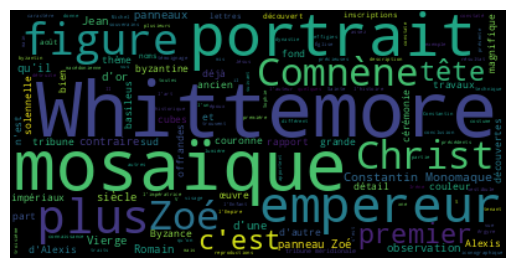

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

index_name = input("Enter le numero de compte-rendu :")

if int(index_name) in df.index :
    text = df.at[int(index_name),"cleaned_text"]
    # Create a wordcloud object
    wordcloud = WordCloud().generate(text)

    # Plot the wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("wordcloud_"+str(index_name)+".png", dpi=300)
    plt.show()
else:
    print("Index not found.")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3bf2fb2c-0dc4-4d0b-b398-8219ba818f30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>